# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **
It can be either. If we consider the output to be categorical and discrete - whether a student requires intervention or not, then it can be a classification problem. However, we could also turn this into a regression problem by using a model that outputs the probability that a student would graduate. In that sense, the output is continuous between 0 and 1. We could prioritize students in our intervention efforts by focusing on students with very low graduation probability.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [23]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [24]:
# TODO: Calculate number of students
n_students = student_data.shape[0]

# TODO: Calculate number of features
n_features = student_data.shape[1] - 1 # minus the target column

# TODO: Calculate passing students
n_passed = student_data[student_data.passed=='yes'].shape[0]

# TODO: Calculate failing students
n_failed = student_data[student_data.passed=='no'].shape[0]

# TODO: Calculate graduation rate
grad_rate = float(n_passed) / float(n_students) * 100.0

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [25]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [26]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [27]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split

random_state = 1

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, train_size=num_train, test_size=num_test, random_state=random_state, stratify=y_all)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. What are the general applications of each model? What are their strengths and weaknesses? Given what you know about the data, why did you choose these models to be applied?*

**Answer: **

#### A. Decision Trees:

This is a straightforward choice. Our dataset has features that are discrete in nature and we have already set up the data such that many of our categorical features have a binary representation. This is a shoe-in for decision trees due to their inherent structure for splitting data into sets of decreasing entropy. 

Decision trees are simple to construct and run so train and predict times are quite low. It's also easy to visualize and explain the resulting model once it has been trained. A downside is that single decision trees can easily overfit so some tuning and pruning is necessary.

Decisions trees are extremely versatile and have applications for object recognition in high level vision, tumor classification in medical research and more generally diagnosing illnesses in many medical fields.

#### B. AdaBoost:

Boosting has been shown to generally do well (source: http://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml06.pdf) and can be applied to both classification and regression depending on the underlying model. So long as we pick a simple weak learner, we can overcome the tendency to overfit as the weighted average at the end will smooth out the variance of the individual models. The accuracy of ensembles tend to come at the cost of training performance. They're not easy to visualize and explain.

Boosting has been successfully used in web search rankings, predictive maintenance of machinery and more generally, a method for incremental learning by training a new model for each new dataset.

#### C. Support Vector Machines:

SVMs are versatile and can be used in both classification and regression. Using different kernels trick allow us to define similarity between two data points. This is equivalent to transforming vectors into feature spaces that allow the points to be linearly separable. The challenge here is finding the appropriate kernel function.

SVMs are known to work well in high dimensional spaces (our dataset has 48) by narrowing down the relevant features to a few 'support' vectors. The downside is that SVMs can take a while to train but since we have < 1000 samples, that shouldn't be much of a problem.

SVMs have also been used in Biomedical research to classify genes and protein sequences, in Physics to classify high-energy electron-positron collisions, in Computer Networking for intrusion detection based on network activity.

#### D. Why not Naive Bayes and K-Nearest Neighbors:

Naive Bayes makes the assumption is that each input feature is independent from every other feature. However, we already know that is not true of this dataset, especially since we replaced categorical features with dummy variables.

K-Nearest Neighbors uses a distance function to determine 'similarity' between two points (similar to SVMs), thus it tends to work better with numerical data that have some quantitative meaning. This is a viable choice, but since we are already using SVM, Decision Trees would be more interesting for comparison.

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [29]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    print "Precision: {:.4f}".format(precision_score(target.values, y_pred, pos_label='yes', average='binary'))
    print "Recall: {:.4f}".format(recall_score(target.values, y_pred, pos_label='yes', average='binary'))
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [47]:
# Import the three supervised learning models from sklearn
from sklearn import svm, naive_bayes, tree, ensemble, neighbors, linear_model

print "\nBenchmark F1 score for all 'yes' on the test set: {:.4f}".format(
    f1_score(y_test, ['yes']*len(y_test), pos_label='yes', average='binary'))
print "Benchmark Precision score for all 'yes' on the test set: {:.4f}".format(
    precision_score(y_test, ['yes']*len(y_test), pos_label='yes', average='binary'))
print "Benchmark Recall score for all 'yes' on the test set: {:.4f}\n".format(
    recall_score(y_test, ['yes']*len(y_test), pos_label='yes', average='binary'))

clfs = [
    naive_bayes.GaussianNB(), 
    neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance'),
    tree.DecisionTreeClassifier(random_state=random_state), 
    ensemble.AdaBoostClassifier(random_state=random_state),
    svm.SVC(random_state=random_state),
]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
for clf in clfs:
    print "#################################################################################"
    print
    for size in [100, 200, 300]:
        train_predict(clf, X_train[:size], y_train[:size], X_test, y_test)
        print


Benchmark F1 score for all 'yes' on the test set: 0.8050
Benchmark Precision score for all 'yes' on the test set: 0.6737
Benchmark Recall score for all 'yes' on the test set: 1.0000

#################################################################################

Training a AdaBoostClassifier using a training set size of 100. . .
Trained model in 0.0676 seconds
Made predictions in 0.0032 seconds.
Precision: 0.7975
Recall: 0.9844
F1 score for training set: 0.8811.
Made predictions in 0.0032 seconds.
Precision: 0.7123
Recall: 0.8125
F1 score for test set: 0.7591.

Training a AdaBoostClassifier using a training set size of 200. . .
Trained model in 0.0639 seconds
Made predictions in 0.0036 seconds.
Precision: 0.7529
Recall: 0.9704
F1 score for training set: 0.8479.
Made predictions in 0.0030 seconds.
Precision: 0.6897
Recall: 0.9375
F1 score for test set: 0.7947.

Training a AdaBoostClassifier using a training set size of 300. . .
Trained model in 0.0734 seconds
Made predictions in 0.0

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - Decision Tree **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.0006                  |  0.0001                |  1.0000          | 0.6829          |
| 200               | 0.0012                  |  0.0001                |  1.0000          | 0.7023          |
| 300               | 0.0017                  |  0.0002                |  1.0000          | 0.6984          |

** Classifer 2 - Adaboosted Decision Trees **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.0603                  | 0.0030                 | 0.9624           | 0.6949          |
| 200               | 0.0644                  | 0.0032                 | 0.8633           | 0.7647          |
| 300               | 0.0717                  | 0.0031                 | 0.8578           | 0.8116          |

** Classifer 3 - SVC **  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.0011                  | 0.0007                 | 0.8591           | 0.8333          |
| 200               | 0.0035                  | 0.0012                 | 0.8581           | 0.8408          |
| 300               | 0.0070                  | 0.0017                 | 0.8584           | 0.8462          |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Chosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **

At 395 samples our available data is the limiting factor at the moment. Training and prediction time for all models are well under 10 ms. This might change in the future as more samples become available, but right now we can simply concern ourselves with model performance. Following this criteria, our SVC model clearly wins out with the best F1 test score. We might still be able to squeeze some more performance with some tuning. Training time is moderate and is likely to scale poorly with additional training data, but unless we expect our student population to suddenly multiply a thousand fold in the next few years, we needn't concern ourselves too much. Moreover, we only likely need to train the model once a year to take updated data into account.

With regards to the other two models: Our decision tree model, while being the speediest, is clearly overfitting evidenced by perfect training scores and rather poor test scores. We can expect it to approach our Adaboosted Decision Tree ensemble performance with some tuning, but likely not much more. Adaboost has the worst training performance time while not doing much better than SVC, so that's a tradeoff that we'd rather not make at the moment.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. For example if you've chosen to use a decision tree or a support vector machine, how does the model go about making a prediction?*

**Answer: **
At the moment we have a 395 student sample with some passed and some failed. We can visualize these students as points a 2D plane where each axis represents some student feature. For example, study time (x-axis) vs absences (y-axis).  The green points represent students that passed, and the red ones represent those that failed. The goal is that in some future time, given some data about a new student, we can predict whether or not this student will pass. To do this, our SVM model finds the line that can best separate the passing students from the failing ones. And when a new student comes in, we can plot his point and find out which side of the line he falls on and that will tell us whether he will pass or fail.

Here we have two lines A and B both cleanly separating failures from successes, but which one is better? Our intuition will lead us to choose A. We can illustrate this by adding a new student with both a high number of absences and study time, it would lie somewhere on the upper right of the graph. If we chose line B, it could misclassify the new data point. Technically, A is better because it maximizes the margin between the two categories, allowing the model to be more robust.

Now most of the time, we can't really separate the data so neatly with a straight line. Sometimes we need something more squiggly and complicated. We can get around this by applying a neat 'kernel' trick. What this kernel does is apply a transformation on our data creating a new dimension, and in that dimension it so happes that we *can* use a straight line to separate the data. We can illustrate it as follows.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [86]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline

# Feature selection to cut some fat
fs = SelectPercentile(f_classif)

# Initialize the classifier
clf = svm.SVC(random_state=random_state)

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes', average='binary')

# Construct a pipeline
pipe = Pipeline([('fs', fs), ('clf', clf)])

# Create the parameters list you wish to tune
parameters = { 
    'fs__percentile': range(20, 31),
    'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'clf__C': [0.01, 0.1, 1., 10.],
    'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 1.],
}

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(pipe, parameters, scoring=f1_scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

print "Best Parameters:", grid_obj.best_params_
print

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Best Parameters: {'clf__gamma': 0.1, 'fs__percentile': 26, 'clf__C': 0.1, 'clf__kernel': 'sigmoid'}

Made predictions in 0.0028 seconds.
Precision: 0.7143
Recall: 0.9453
Tuned model has a training F1 score of 0.8137.
Made predictions in 0.0010 seconds.
Precision: 0.7045
Recall: 0.9688
Tuned model has a testing F1 score of 0.8158.


### Grid Scores Heatmap

We can produce a heatmap of the resulting scores from grid search.

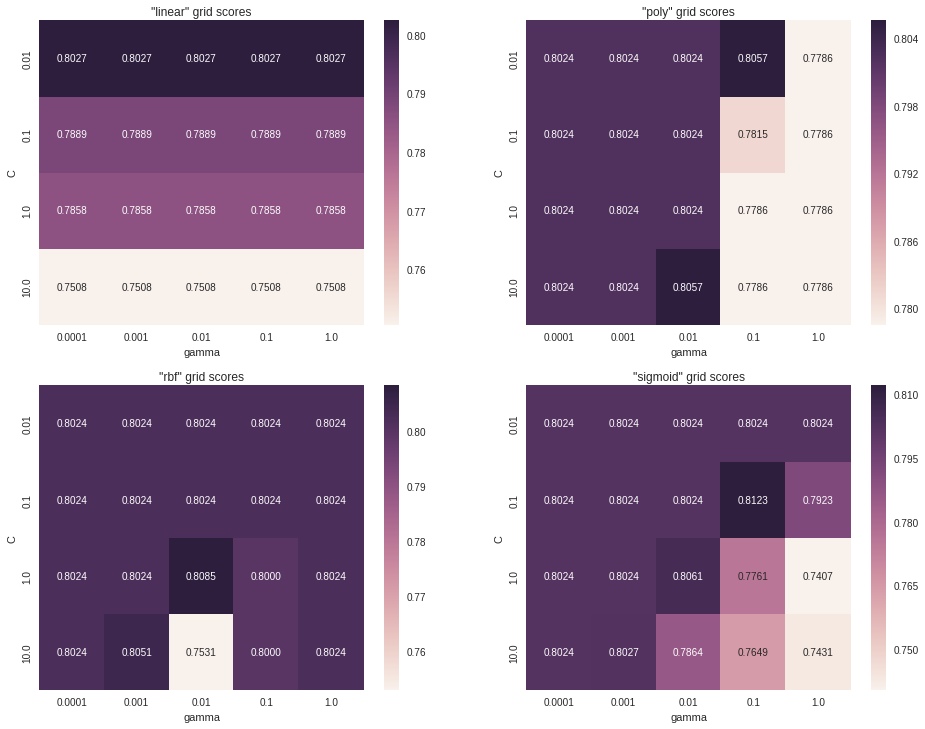

In [32]:
%matplotlib inline
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.figure as fg

grid_scores = pd.DataFrame(
    [[param['kernel'], param['C'], param['gamma'], score] for param, score, _ in grid_obj.grid_scores_], 
    columns=['kernel', 'C', 'gamma', 'score'])
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(16, 12)
for x, y, kernel in zip([0,0,1,1],[0,1,0,1], ['linear', 'poly', 'rbf', 'sigmoid']):
    axes[x][y].set_title('"{}" grid scores'.format(kernel))
    sb.heatmap(grid_scores[grid_scores.kernel==kernel].pivot('C', 'gamma', 'score'), 
               annot=True, fmt='.4f', ax=axes[x][y])

### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

Final F1 Score:  0.8158

It improved marginally - about 1.2%. Our best training score using SVM is only 0.8591 and it is reasonable to think that our test score would do no better than this quantity.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.